In [1]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install wordcloud
!pip install nltk
!pip install scikit-learn


[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import re
import nltk
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

In [3]:
# file_path = 'C:/Users/user/Desktop/Data Science Projects/twittersentimentanalysis.csv'
# df = pd.read_csv(file_path, header=None, encoding='latin1', nrows=30000)
# df.info()


file_path = 'C:/Users/user/Desktop/Data Science Projects/twittersentimentanalysis.csv'
chunk_size = 100000
total_rows = 10_000
sampled_df = pd.DataFrame()

for chunk in pd.read_csv(file_path, header=None, encoding='latin1', chunksize=chunk_size):
    frac = total_rows / (10 * chunk_size)
    sampled_chunk = chunk.sample(frac=frac, random_state=1)
    sampled_df = pd.concat([sampled_df, sampled_chunk])
    if len(sampled_df) >= total_rows:
        break

df = sampled_df.sample(n=total_rows, random_state=1).reset_index(drop=True)

In [4]:

df.columns = ["sentiment", "id", "date", "flag", "user", "text"]
df['sentiment'] = df['sentiment'].map({0:"Negative", 4:"Positive"})
df.head()

,sentiment,id,date,flag,user,text
0,Positive,1827894171,Sun May 17 11:40:06 PDT 2009,NO_QUERY,JonathanEngalla,Seeds of failure r planted in times of success...
1,Negative,2053743649,Sat Jun 06 05:34:01 PDT 2009,NO_QUERY,jennyjardine,aarghhh .. twitter not working on my phone
2,Negative,2185409687,Mon Jun 15 17:20:21 PDT 2009,NO_QUERY,ponylover95,just sitting here doing some home work blah no...
3,Negative,2054119688,Sat Jun 06 06:36:24 PDT 2009,NO_QUERY,Lizzyc88,good morning twit-twits! not a great beach day...
4,Negative,2216374464,Wed Jun 17 19:23:56 PDT 2009,NO_QUERY,jrodn09,Too much lightning!!!


In [5]:
df.dtypes

sentiment    object
id            int64
date         object
flag         object
user         object
text         object
dtype: object

In [6]:

df = df[['sentiment','text']]
df.head()

,sentiment,text
0,Positive,Seeds of failure r planted in times of success...
1,Negative,aarghhh .. twitter not working on my phone
2,Negative,just sitting here doing some home work blah no...
3,Negative,good morning twit-twits! not a great beach day...
4,Negative,Too much lightning!!!


In [7]:
# shape
df.shape

(10000, 2)

In [8]:
# information
df.info()
df.isnull()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  10000 non-null  object
 1   text       10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


,sentiment,text
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
9995,False,False
9996,False,False
9997,False,False
9998,False,False


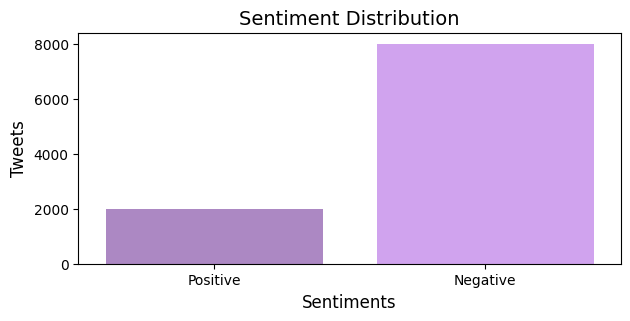

In [9]:
# Positive & Negative Data
plt.figure(figsize=(7,3))
colors = sns.dark_palette("#d397fa", n_colors=10, input='rgb')
sns.countplot(data=df, x='sentiment', palette=[colors[7], colors[9]])
plt.xlabel("Sentiments", size=12)
plt.ylabel('Tweets', size=12)
plt.title("Sentiment Distribution", size=14)
plt.show()

In [10]:
# Random Text Sample Analysis
random_index = [random.randint(0, df.shape[0]) for i in range(10)]
for i in df['text'].loc[random_index]:
    print(i)

@ilovegayboys same im screwed for mids too  and cheer up claudie you sound rly sad 
Going to sleep.Tomorrow the routine again, buu 
R.I.P. Jimmy (My CHUCKS) ... * sad funeral music... they were a good pair of shoes... 
@memachelle Okay, that was messed up....Darn keypad on my laptop, fat fingered the return key  anyway - nice to hear common sense 
Dying to get my iphone 3GS, any chance it will get here a day early? I'm traveling on the 19th 
@saragarth honest,,,, honest??? and omg as if u eating burnt spaghtti, should be eating chocolate 
is hoping for nothing but good developments for my friend whose dealing with way more crap then he deserves right now. 
4 minutes later....................still doin the same thing   
@Maukingbird No  I had to go visit ex inlaws and stuff
Awake! and working on my website! STAY TUNED! 


`Note`: Here we can see the textual data contains
    
1. links
2. mentions (@)
3. other special characters



In [11]:
# All Patterns
mention_pattern = r'@\S+|#\S+'
url_pattern = r"https?:(?:www\.)?\S+"
non_alphanumeric_pattern = r"[^A-Za-z0-9\s]+"

In [12]:
# Data Cleaning Function 
def data_cleaning(text):
    lower_text = str.lower(text)
    clean_text = re.sub(mention_pattern + '|' + url_pattern + '|' + non_alphanumeric_pattern, ' ', lower_text)
    return clean_text

In [13]:
# Performing Data Cleaning
df['text'] = df['text'].apply(data_cleaning)
df['text']

0       seeds of failure r planted in times of success...
1              aarghhh   twitter not working on my phone 
2       just sitting here doing some home work blah no...
3       good morning twit twits  not a great beach day...
4                                    too much lightning  
                              ...                        
9995       nope    guess google has just made me a bit...
9996    i really want to go and see  wicked the musica...
9997                           yeah i was talkin about u 
9998      we all thought you guys were gonna pull out ...
9999      thank you for being a great character on hou...
Name: text, Length: 10000, dtype: object

In [14]:
import nltk

In [15]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
!pip install tqdm
from tqdm import tqdm
tqdm.pandas()

df['tokenized text'] = df['text'].progress_apply(lambda document: word_tokenize(document.strip()))


[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 14007.62it/s]


In [17]:
df['tokenized text']

0       [seeds, of, failure, r, planted, in, times, of...
1         [aarghhh, twitter, not, working, on, my, phone]
2       [just, sitting, here, doing, some, home, work,...
3       [good, morning, twit, twits, not, a, great, be...
4                                  [too, much, lightning]
                              ...                        
9995    [nope, guess, google, has, just, made, me, a, ...
9996    [i, really, want, to, go, and, see, wicked, th...
9997                     [yeah, i, was, talkin, about, u]
9998    [we, all, thought, you, guys, were, gon, na, p...
9999    [thank, you, for, being, a, great, character, ...
Name: tokenized text, Length: 10000, dtype: object

In [18]:
nltk.download('stopwords')

# Getting list of stopwords
stop_words = set(stopwords.words('english'))
df['clean_tokens'] = df['tokenized text'].progress_apply(lambda tokens: [token for token in tokens if token not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 300733.78it/s]


In [19]:
df['clean_tokens']

0       [seeds, failure, r, planted, times, success, s...
1                      [aarghhh, twitter, working, phone]
2       [sitting, home, work, blah, fun, yay, exams, c...
3       [good, morning, twit, twits, great, beach, day...
4                                       [much, lightning]
                              ...                        
9995             [nope, guess, google, made, bit, spoilt]
9996     [really, want, go, see, wicked, musical, sydney]
9997                                    [yeah, talkin, u]
9998    [thought, guys, gon, na, pull, 9th, inning, ma...
9999       [thank, great, character, house, sad, see, go]
Name: clean_tokens, Length: 10000, dtype: object

In [20]:
# To Avoid Error that might occur, if we try running lematization
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [21]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
# Appling Lemmatization on Clean Tokens
lemmatizer = WordNetLemmatizer()
df['lemmatized text'] = df['clean_tokens'].progress_apply(lambda tokens: ' '.join([lemmatizer.lemmatize(token, pos='v') for token in tokens]))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2787.24it/s]


In [23]:
df['lemmatized text']

0       seed failure r plant time success seed succe r...
1                              aarghhh twitter work phone
2               sit home work blah fun yay exams come yay
3       good morning twit twit great beach day whats e...
4                                          much lightning
                              ...                        
9995                    nope guess google make bite spoil
9996             really want go see wicked musical sydney
9997                                        yeah talkin u
9998               think guy gon na pull 9th inning magic
9999               thank great character house sad see go
Name: lemmatized text, Length: 10000, dtype: object

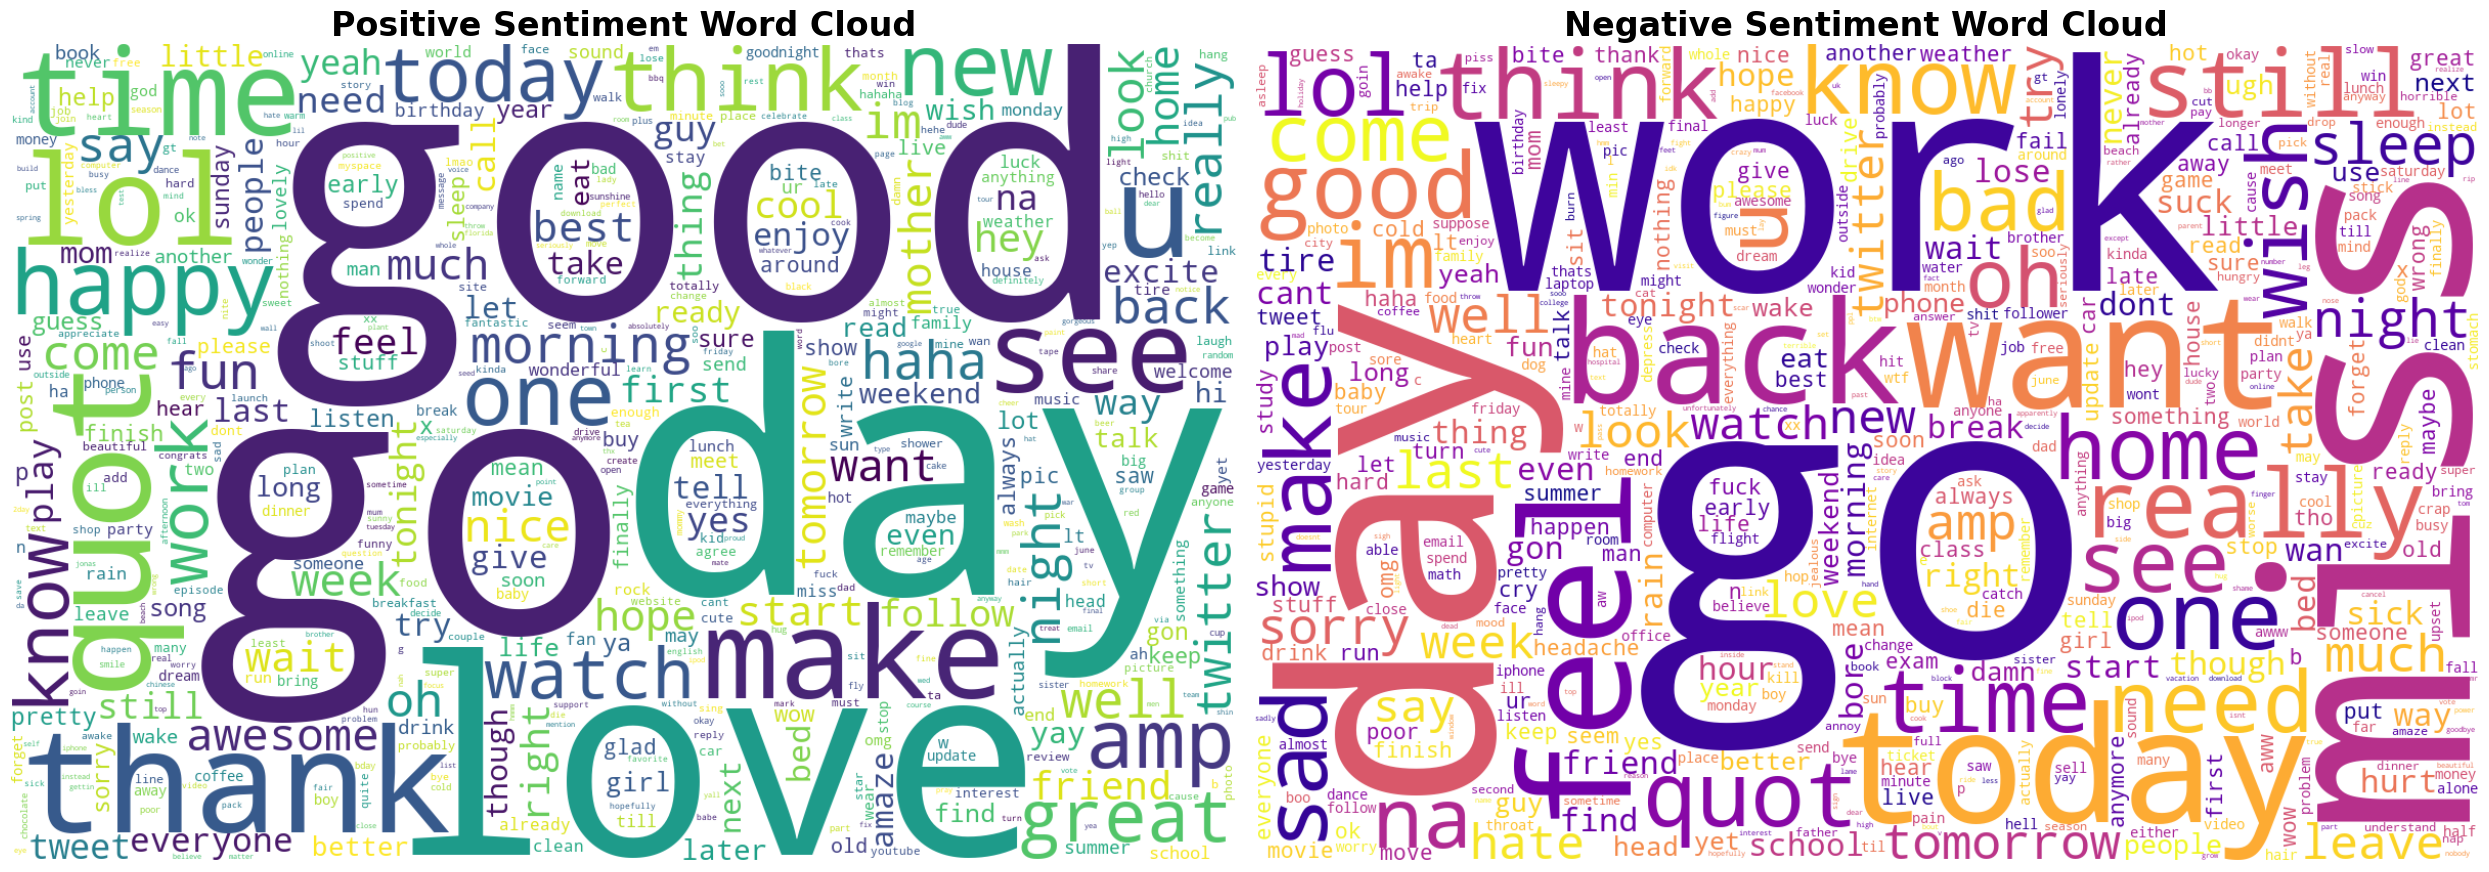

In [24]:
# Filter out positive and negative sentiment data
positive = df[df['sentiment'] == 'Positive']['lemmatized text']
negative = df[df['sentiment'] == 'Negative']['lemmatized text']

# Combine text data into single strings
positive_data = " ".join(positive)
negative_data = " ".join(negative)

# Create WordCloud objects
wc_positive = WordCloud(max_words=500, width=1200, height=800, background_color='white', colormap='viridis',
              contour_color='black', contour_width=1, collocations=False, random_state=42).generate(positive_data)

wc_negative = WordCloud(max_words=500, width=1200, height=800, background_color='white', colormap='plasma',
              contour_color='black', contour_width=1, collocations=False, random_state=42).generate(negative_data)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Plot positive sentiment word cloud
axes[0].imshow(wc_positive, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Positive Sentiment Word Cloud", fontsize=24, fontweight='bold')

# Plot negative sentiment word cloud
axes[1].imshow(wc_negative, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Negative Sentiment Word Cloud", fontsize=24, fontweight='bold')

plt.tight_layout()
plt.show()

In [25]:
# Creating new features
df['no_of_charcters'] = df['lemmatized text'].progress_apply(len)
df['no_of_words'] = df['lemmatized text'].progress_apply(lambda document: word_tokenize(document)).apply(len)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 20008.24it/s]


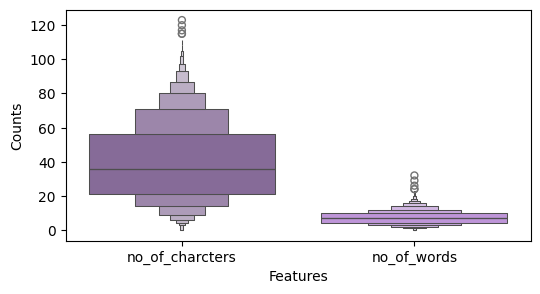

In [26]:
# Plotting Boxplot
plt.figure(figsize=(6,3))
colors = sns.dark_palette("#d397fa", n_colors=10, input='rgb')
sns.boxenplot(df[['no_of_charcters', 'no_of_words']], palette=[colors[5], colors[8]])
plt.xlabel("Features")
plt.ylabel("Counts")
plt.show()

In [27]:

df = df[(df['no_of_charcters']<100) & (df['no_of_words']<20)]
df

,sentiment,text,tokenized text,clean_tokens,lemmatized text,no_of_charcters,no_of_words
0,Positive,seeds of failure r planted in times of success...,"[seeds, of, failure, r, planted, in, times, of...","[seeds, failure, r, planted, times, success, s...",seed failure r plant time success seed succe r...,84,16
1,Negative,aarghhh twitter not working on my phone,"[aarghhh, twitter, not, working, on, my, phone]","[aarghhh, twitter, working, phone]",aarghhh twitter work phone,26,4
2,Negative,just sitting here doing some home work blah no...,"[just, sitting, here, doing, some, home, work,...","[sitting, home, work, blah, fun, yay, exams, c...",sit home work blah fun yay exams come yay,41,9
3,Negative,good morning twit twits not a great beach day...,"[good, morning, twit, twits, not, a, great, be...","[good, morning, twit, twits, great, beach, day...",good morning twit twit great beach day whats e...,59,10
4,Negative,too much lightning,"[too, much, lightning]","[much, lightning]",much lightning,14,2
...,...,...,...,...,...,...,...
9995,Negative,nope guess google has just made me a bit...,"[nope, guess, google, has, just, made, me, a, ...","[nope, guess, google, made, bit, spoilt]",nope guess google make bite spoil,33,6
9996,Negative,i really want to go and see wicked the musica...,"[i, really, want, to, go, and, see, wicked, th...","[really, want, go, see, wicked, musical, sydney]",really want go see wicked musical sydney,40,7
9997,Negative,yeah i was talkin about u,"[yeah, i, was, talkin, about, u]","[yeah, talkin, u]",yeah talkin u,13,3
9998,Negative,we all thought you guys were gonna pull out ...,"[we, all, thought, you, guys, were, gon, na, p...","[thought, guys, gon, na, pull, 9th, inning, ma...",think guy gon na pull 9th inning magic,38,8


In [28]:
# splitting the dataset
X = df['lemmatized text']
y = df['sentiment'].apply(lambda x: 0 if x == 'Negative' else 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [29]:
# Applying Vectorization Techniques
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(tqdm(X_train, desc="Vectorizing Text"))

Vectorizing Text: 100%|█████████████████████████████████████████████████████████| 7441/7441 [00:00<00:00, 63669.07it/s]


TfidfVectorizer(ngram_range=(1, 2))

In [30]:
X_train = vectorizer.transform(tqdm(X_train))
X_test = vectorizer.transform(tqdm(X_test))

100%|███████████████████████████████████████████████████████████████████████████| 2481/2481 [00:00<00:00, 65207.87it/s]


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_squared_error, r2_score

random_forest = RandomForestClassifier(n_estimators=5, random_state=42)
random_forest.fit(X_train, y_train)
rf_train_pred = random_forest.predict(X_train)
rf_test_pred = random_forest.predict(X_test)
rf_metrics = {
    "Training Accuracy": accuracy_score(y_train, rf_train_pred),
    "Testing Accuracy": accuracy_score(y_test, rf_test_pred),
    "Recall": recall_score(y_test, rf_test_pred, average='weighted'),
    "Precision": precision_score(y_test, rf_test_pred, average='weighted'),
    "F1 Score": f1_score(y_test, rf_test_pred, average='weighted'),
    "RMSE": np.sqrt(mean_squared_error(y_train, rf_train_pred)),
    "R-squared": r2_score(y_train, rf_train_pred)
}

rf_metrics


{'Training Accuracy': 0.9645208977287999,
 'Testing Accuracy': 0.7875856509471987,
 'Recall': 0.7875856509471987,
 'Precision': 0.7537664043582373,
 'F1 Score': 0.7623437018859559,
 'RMSE': 0.18835897183622582,
 'R-squared': 0.7765380058205883}

In [32]:
from sklearn.svm import SVC

In [33]:

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_train_pred = svm_model.predict(X_train)
svm_test_pred = svm_model.predict(X_test)
svm_metrics = {
    "Training Accuracy": accuracy_score(y_train, svm_train_pred),
    "Testing Accuracy": accuracy_score(y_test, svm_test_pred),
    "Recall": recall_score(y_test, svm_test_pred, average='weighted'),
    "Precision": precision_score(y_test, svm_test_pred, average='weighted'),
    "F1 Score": f1_score(y_test, svm_test_pred, average='weighted'),
    "RMSE": np.sqrt(mean_squared_error(y_train, svm_train_pred)),
    "R-squared": r2_score(y_train, svm_train_pred)
}

svm_metrics

{'Training Accuracy': 0.9638489450342695,
 'Testing Accuracy': 0.8170092704554615,
 'Recall': 0.8170092704554615,
 'Precision': 0.792158626980661,
 'F1 Score': 0.7822457059347079,
 'RMSE': 0.1901343077030824,
 'R-squared': 0.7723057710823418}

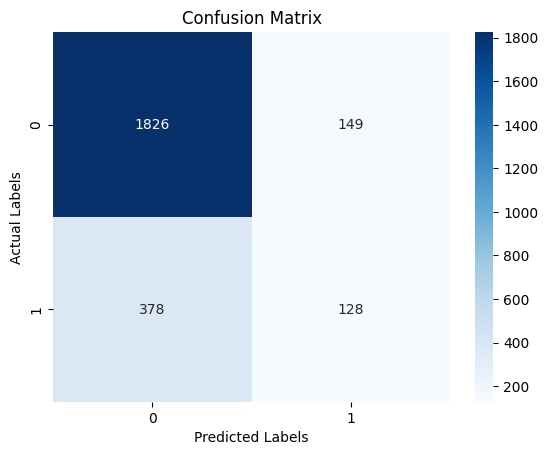

In [34]:
cm = confusion_matrix(y_test, rf_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

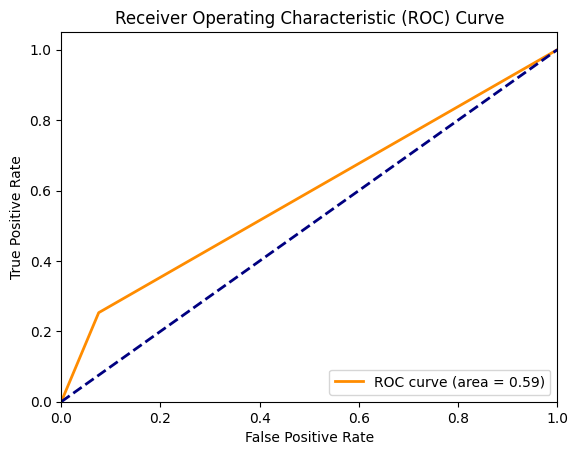

In [35]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

fpr, tpr, thresholds = roc_curve(y_test, rf_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()